# Imports

In [127]:
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [128]:
import numpy as np
import pandas as pd

#Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

#Audio libraries
import librosa
import librosa.display
import noisereduce as nr

In [114]:
#Importing the models
import sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Metric
from sklearn.metrics import accuracy_score

#Utils
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#Pretty Table
from prettytable import PrettyTable

# 0. Importing the datasets 

In [4]:
dev_df = pd.read_csv('dsl_data/development.csv', index_col='Id')
eval_df = pd.read_csv('dsl_data/evaluation.csv', index_col='Id')

dev_df.shape, eval_df.shape

((9854, 9), (1455, 7))

In [5]:
dev_df.head(5)

,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
Id,,,,,,,,,
0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40


In [6]:
eval_df.head(5)

,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
Id,,,,,,,
0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
2,dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d5...,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65
3,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
4,dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a...,V4ZbwLm9G5irobWn,native,English (United States),English (United States),female,41-65


# 1. Dataset Exploration

## 1.1 Development dataset

In [7]:
#Searching for missing values

dev_df.isnull().sum()

path                                     0
speakerId                                0
action                                   0
object                                   0
Self-reported fluency level              0
First Language spoken                    0
Current language used for work/school    0
gender                                   0
ageRange                                 0
dtype: int64

In [8]:
#Concatenating action and object features of the development dataset

dev_df['action_object'] = dev_df['action'] + dev_df['object']
dev_df = dev_df.drop(columns=['action', 'object'])

dev_df.shape

(9854, 8)

In [9]:
#Exploring the unique values of each columns except for path feature

for col in dev_df.columns[1:]:
    print('Feature = ', col)
    print('Unique values:', len(dev_df[col].unique()))
    print(dev_df[col].unique())
    print('\n')

Feature =  speakerId
Unique values: 87
['2BqVo8kVB2Skwgyb' '2ojo7YRL7Gck83Z3' '35v28XaVEns4WXOv'
 '4aGjX3AG5xcxeL7a' '52XVOeXMXYuaElyw' '5BEzPgPKe8taG9OB'
 '5o9BvRGEGvhaeBwA' '5pa4DVyvN2fXpepb' '73bEEYMKLwtmVwV43'
 '7NEaXjeLX3sg3yDB' '8e5qRjN7dGuovkRY' '9EWlVBQo9rtqRYdy'
 '9Gmnwa5W9PIwaoKq' '9mYN2zmq7aTw4Blo' 'anvKyBjB5OiP5dYZ'
 'AvR9dePW88IynbaE' 'AY5e3mMgZkIyG3Ox' 'BvyakyrDmQfWEABb'
 'd2waAp3pEjiWgrDEY' 'd3erpmyk9yFlVyrZ' 'DMApMRmGq5hjkyvX'
 'DWmlpyg93YCXAXgE' 'EExgNZ9dvgTE3928' 'eL2w4ZBD7liA85wm'
 'eLQ3mNg27GHLkDej' 'g2dnA9Wpvzi2WAmZ' 'G3QxQd7qGRuXAZda'
 'gNYvkbx3gof2Y3V9' 'gvKeNY2D3Rs2jRdL' 'Gym5dABePPHA8mZK9'
 'jgxq52DoPpsR9ZRx' 'KLa5k73rZvSlv82X' 'kNnmb7MdArswxLYw'
 'KqDyvgWm4Wh8ZDM7' 'kxgXN97ALmHbaezp' 'ldrknAmwYPcWzp4N'
 'LR5vdbQgp3tlMBzB' 'M4ybygBlWqImBn9oZ' 'mor8vDGkaOHzLLWBp'
 'mzgVQ4Z5WvHqgNmY' 'n5XllaB4gZFwZXkBz' 'neaPN7GbBEUex8rV'
 'nO2pPlZzv3IvOQoP2' 'NWAAAQQZDXC5b9Mk' 'ObdQbr9wyDfbmW4E'
 'OepoQ9jWQztn5ZqL' 'oNOZxyvRe3Ikx3La' 'oRrwPDNPlAieQr8Q'
 'oXjpaOq4wVUezb3x' 'ppzZq

We can see there are 7 unique combinations of action + object, which are the target of the classification task.

## 1.2 Evaluation dataset

In [10]:
#Searching for missing values in the development set

eval_df.isnull().sum()

path                                     0
speakerId                                0
Self-reported fluency level              0
First Language spoken                    0
Current language used for work/school    0
gender                                   0
ageRange                                 0
dtype: int64

In [11]:
#Exploring the unique values of each columns except for path feature

for col in eval_df.columns[1:]:
    print('Feature = ', col)
    print('Unique values:', len(eval_df[col].unique()))
    print(eval_df[col].unique())
    print('\n')

Feature =  speakerId
Unique values: 10
['NgQEvO2x7Vh3xy2xz' 'k5bqyxx2lzIbrlg9' '7B4XmNppyrCK977p'
 'V4ZbwLm9G5irobWn' 'V4ejqNL4xbUKkYrV' '4BrX8aDqK2cLZRYl'
 'aokxBz9LxXHzZzay' 'ppymZZDb2Bf4NQnE' 'oOK5kxoW7dskMbaK'
 'Q4vMvpXkXBsqryvZ']


Feature =  Self-reported fluency level 
Unique values: 1
['native']


Feature =  First Language spoken
Unique values: 1
['English (United States)']


Feature =  Current language used for work/school
Unique values: 1
['English (United States)']


Feature =  gender
Unique values: 2
['male' 'female']


Feature =  ageRange
Unique values: 2
['22-40' '41-65']




The evaluation dateset contain less variety of features with respect to the development set, in fact there is only a single value for the features *'Self-reported fluency level'*, *'First Language spoken'*, *'Current language used for work/school'* and two of the three values for the *'ageRange'* feature.

## 1.3 Conclusions

After having seen the differences in the variety features, it needs to be inspected if this features are important alongside the features extracted from the audio file to determine the intent expressed in the audio. This will be done in the **Features selection part**.

# 2. Feature analysis

In this section a deeper feature analysis is performed in order to understand the values distributions.

## 2.1 Development set

### 2.1.1 Speaker features' distributions

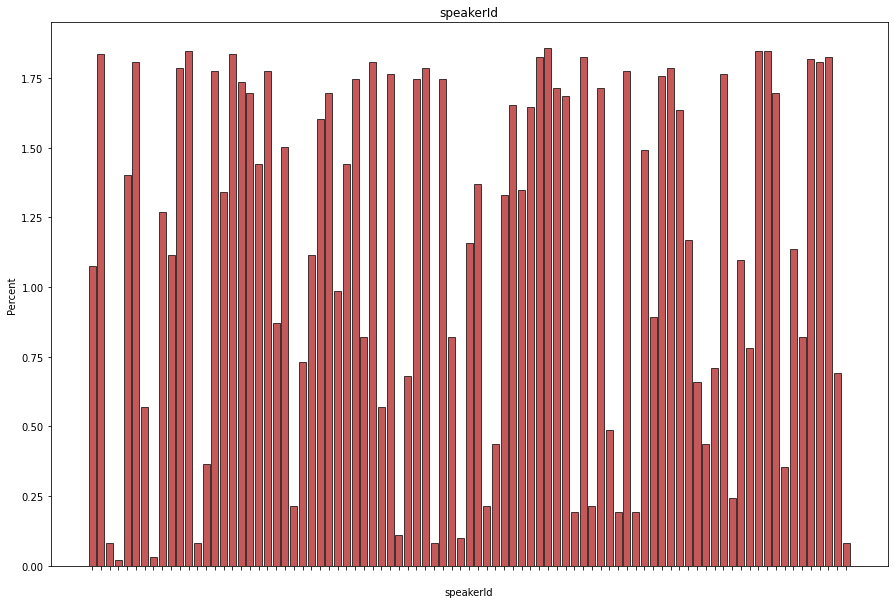

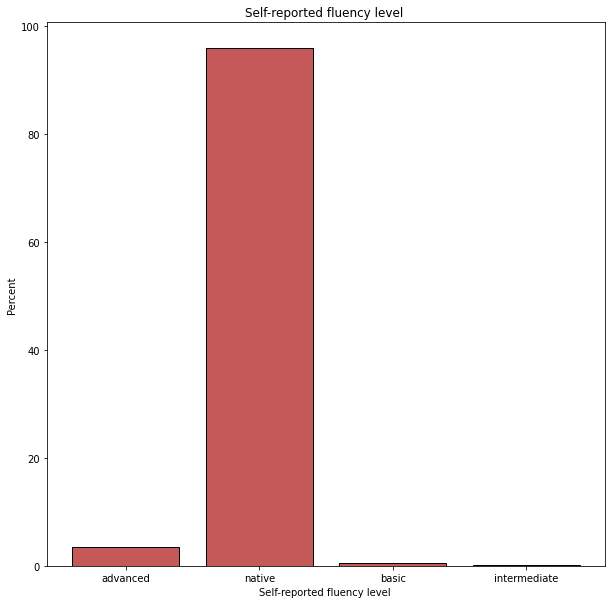

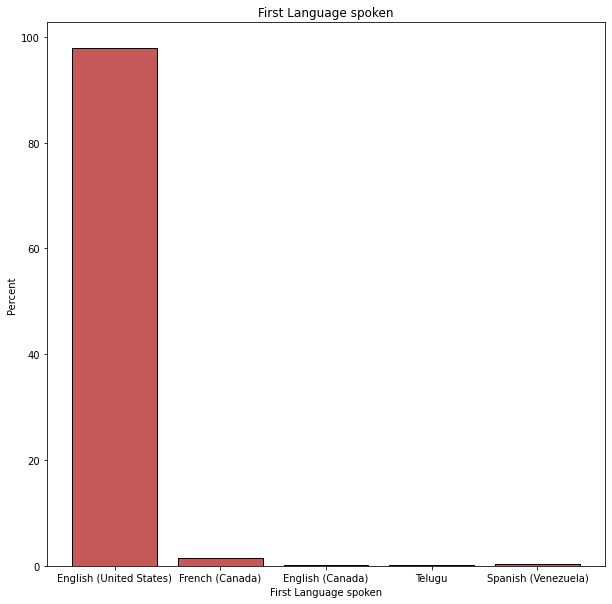

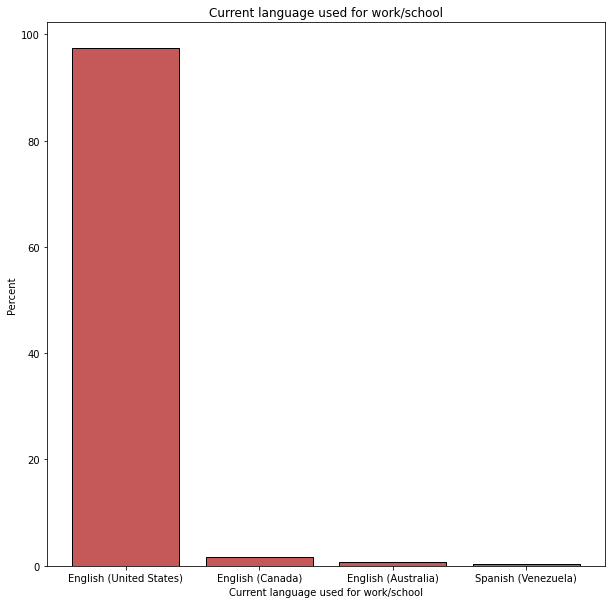

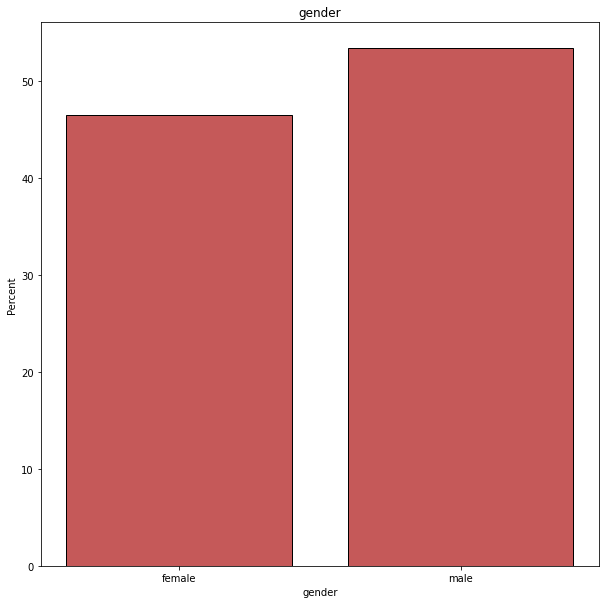

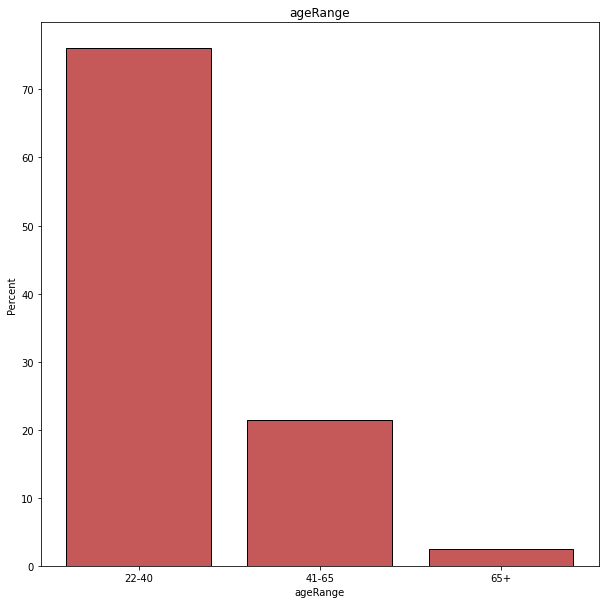

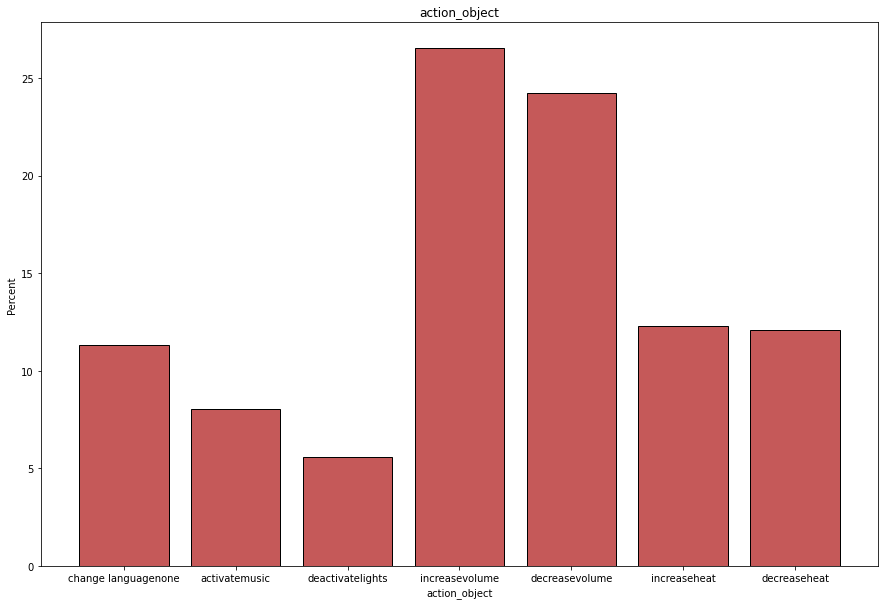

In [136]:
#Plot the distribution of the features except for 'path' feature

to_plot = dev_df.columns.drop(['path'])

for i in range(0,len(to_plot)):
  if(i==0):
    plt.figure(figsize=(15,10))
    plt.title(f'{to_plot[i]}')
    g = sns.histplot(dev_df[f'{to_plot[i]}'], stat='percent', color='firebrick', shrink=.8)
    g.set_xticklabels([' ']*len(dev_df.iloc[:,i].unique()))
    plt.show()
  
  if(i==len(to_plot)-1):
    plt.figure(figsize=(15,10))
    plt.title(f'{to_plot[i]}')
    g = sns.histplot(dev_df[f'{to_plot[i]}'], stat='percent', color='firebrick', shrink=.8)
    plt.show()
  
  elif(i>0 and i<len(to_plot)-1): 
    plt.figure(figsize=(10,10))
    plt.title(f'{to_plot[i]}')
    g = sns.histplot(dev_df[f'{to_plot[i]}'], stat='percent', color='firebrick', shrink=.8)
    plt.show()

The dataset is heavily unbalanced, on each feature, except for gender. Even the labels are not uniformly distributed.

### 2.1.2 Audio insights

In [47]:
#Opening all the audio files to obtain length and samplerate

dev_audio_df = pd.DataFrame(columns=['sr', 'length'])

for path in tqdm(dev_df['path']):
  signal, sr = librosa.load(path, sr=None)
  length = signal.shape[0] / sr
  new_row = pd.Series([sr, length], index=dev_audio_df.columns)
  dev_audio_df = pd.concat([dev_audio_df, new_row.to_frame().T], ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 9854/9854 [00:10<00:00, 952.34it/s]


In [48]:
print(dev_audio_df['sr'].value_counts())
print('\n')

print(dev_audio_df['length'].describe())

16000.0    9554
22050.0     300
Name: sr, dtype: int64


count    9854.000000
mean        2.639782
std         3.133639
min         0.650188
25%         1.706687
50%         2.043375
75%         2.414875
max        20.000000
Name: length, dtype: float64


It is possible to see that data are not sampled with the same samplerate. Futhermore the audios have very different lenghts, from a min of 0.65 seconds to a max of 20 seconds.

## 2.2 Evaluation dataset

### 2.2.1 Speaker features' distributions

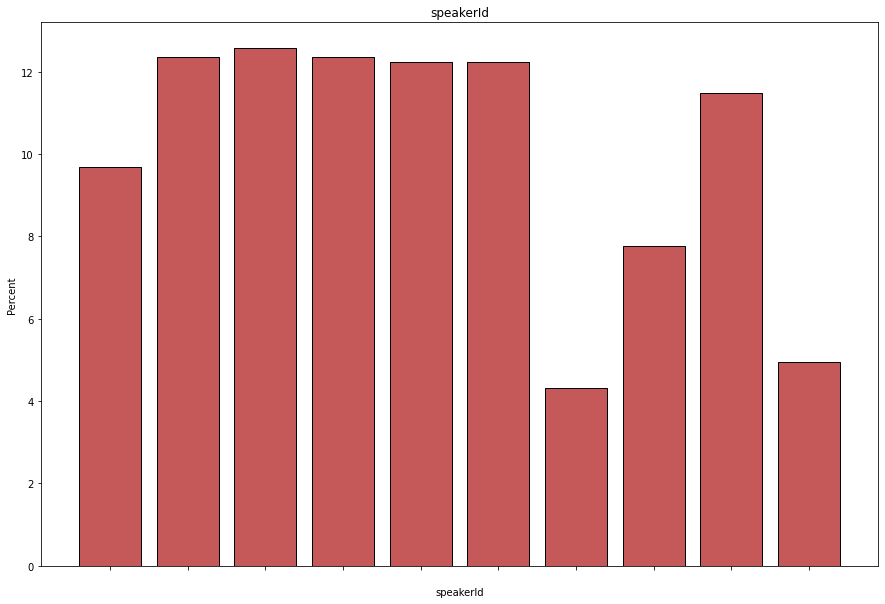

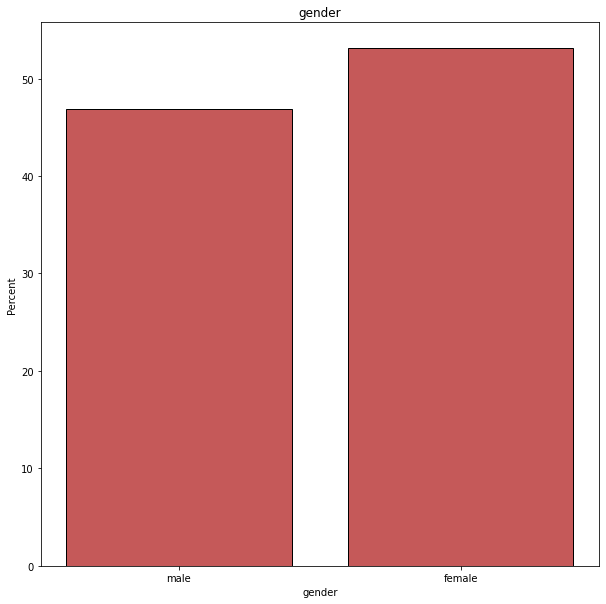

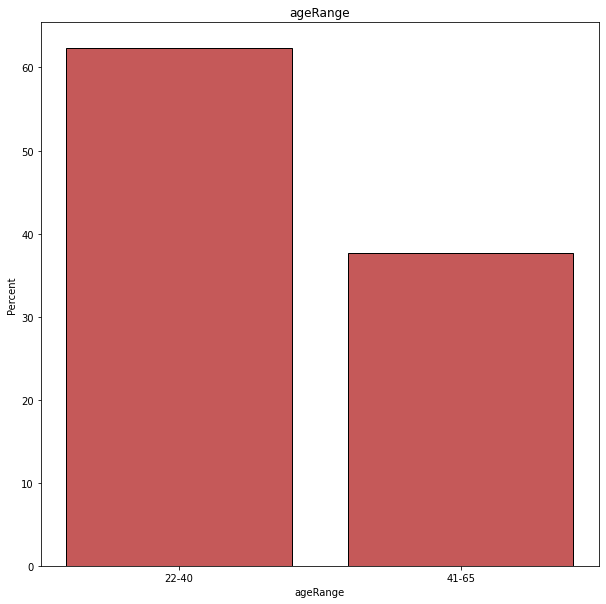

In [139]:
#Plot the distribution of the features except for 'path' feature and the features that present only one value

to_plot = eval_df.columns.drop(['path', 'Self-reported fluency level ', 'First Language spoken', 'Current language used for work/school'])

for i in range(0,len(to_plot)):
  if(i==0):
    plt.figure(figsize=(15,10))
    plt.title(f'{to_plot[i]}')
    g = sns.histplot(eval_df[f'{to_plot[i]}'], stat='percent', color='firebrick', shrink=.8)
    g.set_xticklabels([' ']*len(eval_df.iloc[:,i].unique()))
    plt.show()
  
  elif(i>0 and i<len(to_plot)): 
    plt.figure(figsize=(10,10))
    plt.title(f'{to_plot[i]}')
    g = sns.histplot(eval_df[f'{to_plot[i]}'], stat='percent', color='firebrick', shrink=.8)
    plt.show()

The evaluation dataset is more balanced, even thoug do not contain all the variety of features of the development one.

### 2.2.2 Audio insights

In [49]:
#Opening all the audio files to obtain length and samplerate

eval_audio_df = pd.DataFrame(columns=['sr', 'length'])

for path in tqdm(eval_df['path']):
  signal, sr = librosa.load(path, sr=None)
  length = signal.shape[0] / sr
  new_row = pd.Series([sr, length], index=dev_audio_df.columns)
  eval_audio_df = pd.concat([eval_audio_df, new_row.to_frame().T], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1455/1455 [00:15<00:00, 93.74it/s]


In [50]:
print(eval_audio_df['sr'].value_counts())
print('\n')

print(eval_audio_df['length'].describe())

16000.0    1455
Name: sr, dtype: int64


count    1455.000000
mean        2.263499
std         0.512964
min         0.682688
25%         1.950500
50%         2.218688
75%         2.560000
max         4.522687
Name: length, dtype: float64


It is possible to see that data here are sampled with the same samplerate. Futhermore the audios lenghts are more similar the the one on the development set, not containing audios of 20s length.

# 3. Preprocessing

This section contains all the transformations required to prepare the data. The preprocessing part is divided into preprocessing of the speaker features and audio preprocessing.

## 3.1 Speaker features preprocessing

About this features, the preprocessing consist in a one-hot encoding of all the features, creating a new dataframe

### 3.1.1 Development dataset

In [12]:
#One-hot encoding of all the features except for 'path', 'speakerId', and the label 'action-object'

features_dev_df = pd.get_dummies(dev_df.iloc[:,2:-1])
features_dev_df.shape

(9854, 18)

In [13]:
features_dev_df.head(5)

,Self-reported fluency level _advanced,Self-reported fluency level _basic,Self-reported fluency level _intermediate,Self-reported fluency level _native,First Language spoken_English (Canada),First Language spoken_English (United States),First Language spoken_French (Canada),First Language spoken_Spanish (Venezuela),First Language spoken_Telugu,Current language used for work/school_English (Australia),Current language used for work/school_English (Canada),Current language used for work/school_English (United States),Current language used for work/school_Spanish (Venezuela),gender_female,gender_male,ageRange_22-40,ageRange_41-65,ageRange_65+
Id,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0
2,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0
3,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0
4,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0


### 3.1.2 Evaluation dataset

In [15]:
#One-hot encoding of all the features except for 'path', 'speakerId'

features_eval_df = pd.get_dummies(eval_df.iloc[:,2:])
features_eval_df.shape

(1455, 7)

In [16]:
features_eval_df.head(5)

,Self-reported fluency level _native,First Language spoken_English (United States),Current language used for work/school_English (United States),gender_female,gender_male,ageRange_22-40,ageRange_41-65
Id,,,,,,,
0,1,1,1,0,1,1,0
1,1,1,1,0,1,1,0
2,1,1,1,0,1,0,1
3,1,1,1,0,1,1,0
4,1,1,1,1,0,0,1


The evaluation dataset present less variety in the features, so the one_hot encoded dataframe has less columns. So there is the need to remove this differences in order to perform the classification of the evaluation set. This is done manually, inserting the missing columns with all zeros.

In [17]:
temp = pd.DataFrame(np.zeros((len(features_eval_df),len(features_dev_df.columns)), dtype=int), columns=features_dev_df.columns)
for column in features_eval_df.columns:
  temp[column] = features_eval_df[column]
  
features_eval_df_full = temp
features_eval_df_full.shape

(1455, 18)

In [18]:
features_eval_df_full.head(5)

,Self-reported fluency level _advanced,Self-reported fluency level _basic,Self-reported fluency level _intermediate,Self-reported fluency level _native,First Language spoken_English (Canada),First Language spoken_English (United States),First Language spoken_French (Canada),First Language spoken_Spanish (Venezuela),First Language spoken_Telugu,Current language used for work/school_English (Australia),Current language used for work/school_English (Canada),Current language used for work/school_English (United States),Current language used for work/school_Spanish (Venezuela),gender_female,gender_male,ageRange_22-40,ageRange_41-65,ageRange_65+
0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0
1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0
2,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0
3,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0
4,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0


## 3.2 Audio preprocessing

The audio preprocessing part consist of:
* peak normalization
* offset removal
* noise reduction
* silent parts trim

Then about the feature extraction:
* computing mel spectrogram and reducing the number of features obtained by chunking and taking mean and std of each chunk
* computing the first 13 mfccs and reducing the number of featurse by taking the mean and std of each mfcc
* computing the zero crossing rate and taking the mean values
* computing the root mean square energy and taking the mean value

An example of this pipeline, step-by-step is now reported.

### 3.2.1 Example

In [179]:
#Parameters used for frequency features extraction:
#n_fft: number of samples in a fast fourier transform window
#hop_length: number of samples between two windows

N_FFT = 512
HOP_LENGTH = 256

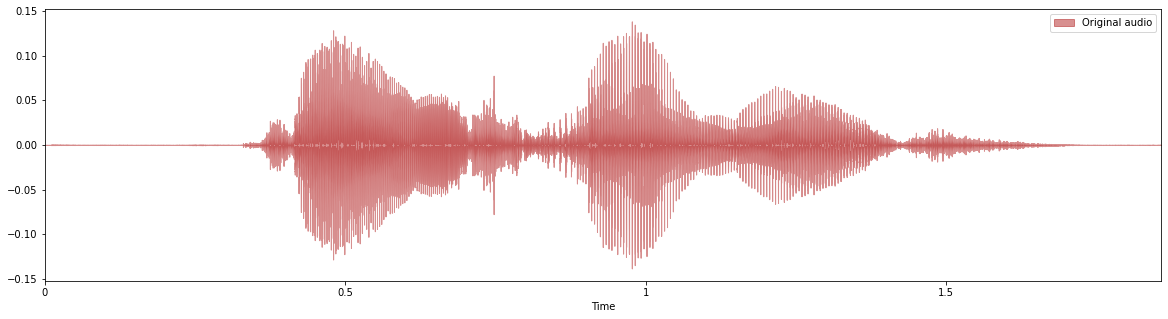

In [148]:
#Loading and plottig the audio file

original_signal, sr = librosa.load(dev_df['path'][0], sr=None)

plt.figure(figsize=(20,5))
librosa.display.waveplot(original_signal, sr=sr, color='firebrick', alpha=0.5, label='Original audio')
plt.legend()
plt.show()

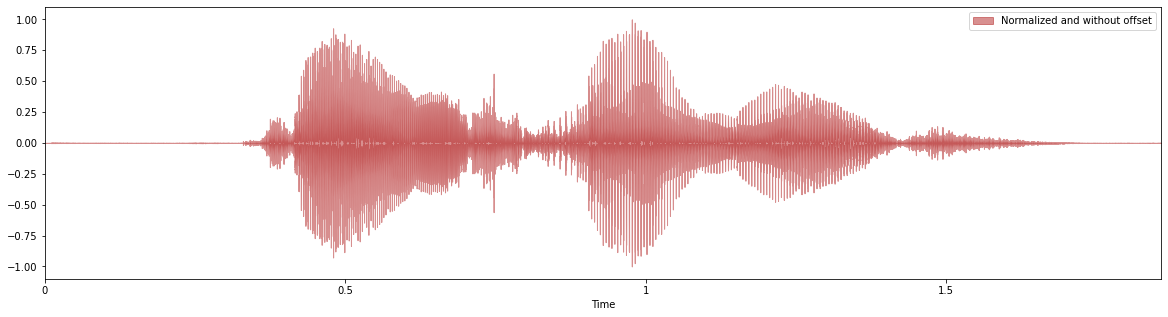

In [150]:
#Peak normalization and offset removal

po_signal = original_signal / original_signal.max()
po_signal = po_signal - po_signal.mean()

plt.figure(figsize=(20,5))
librosa.display.waveplot(po_signal, sr=sr, alpha=0.5, color='firebrick', label='Normalized and without offset')
plt.legend()
plt.show()

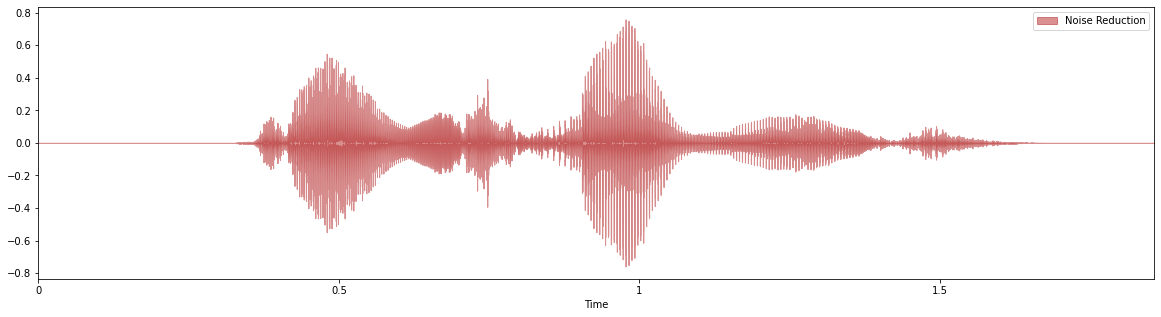

In [151]:
#Noise reduction

nr_signal = nr.reduce_noise(po_signal, sr)

plt.figure(figsize=(20,5))
librosa.display.waveplot(nr_signal, sr=sr, alpha=0.5, color='firebrick', label='Noise Reduction')
plt.legend()
plt.show()

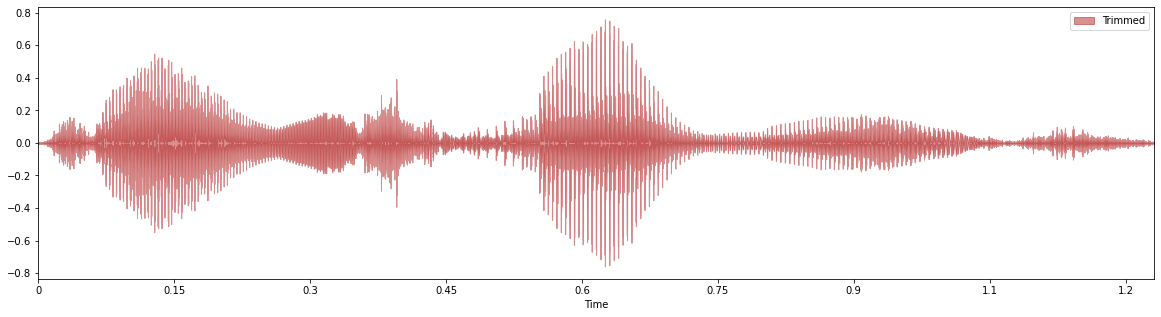

In [163]:
#Trim silent parts

trimmed_signal, _ = librosa.effects.trim(nr_signal, top_db=30, frame_length=N_FFT, hop_length=HOP_LENGTH)

plt.figure(figsize=(20,5))
librosa.display.waveplot(trimmed_signal, sr=sr, alpha=0.5, color='firebrick', label='Trimmed')
plt.legend(loc='upper right')
plt.show()

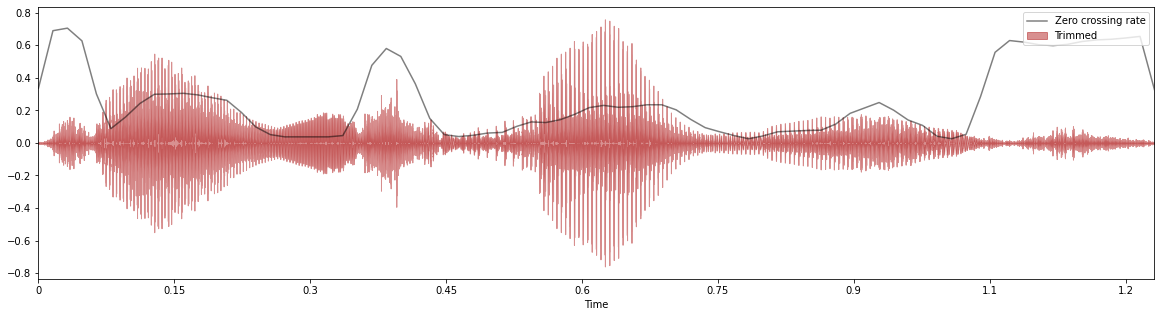

mean: 0.2522536057692308


In [165]:
#Computing zero crossing rate

zcr = librosa.feature.zero_crossing_rate(y=trimmed_signal, frame_length=N_FFT, hop_length=HOP_LENGTH)[0]

frames = range(len(zcr))
t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

plt.figure(figsize=(20,5))
librosa.display.waveplot(trimmed_signal, sr=sr, color='firebrick', alpha=0.5, label='Trimmed')
plt.plot(t, zcr, color='black', alpha=0.5, label='Zero crossing rate')
plt.legend(loc='upper right')
plt.show()

res = np.mean(zcr, axis=-1)
print(f'mean: {res}')

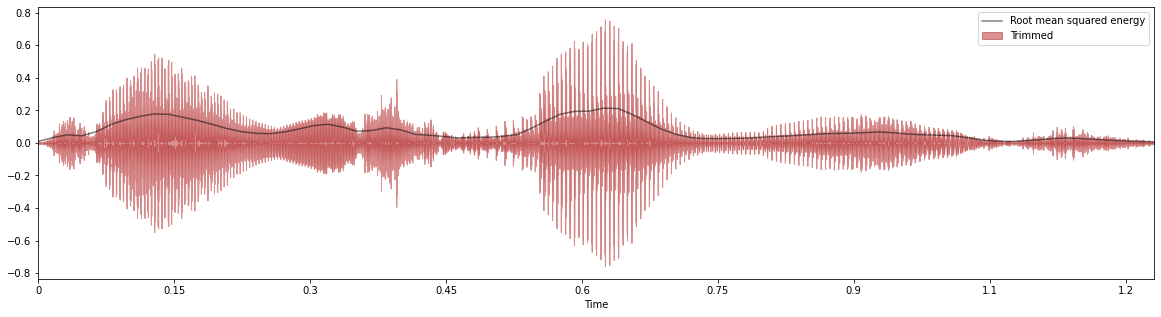

mean: 0.07119695097208023


In [167]:
#Computing root mean square energy and taking the mean

rms = librosa.feature.rms(y=trimmed_signal, frame_length=N_FFT, hop_length=HOP_LENGTH)[0]

frames = range(len(rms))
t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

plt.figure(figsize=(20,5))
librosa.display.waveplot(trimmed_signal, sr=sr, color='firebrick', alpha=0.5, label='Trimmed')
plt.plot(t, rms, color='black', alpha=0.5, label='Root mean squared energy')
plt.legend(loc='upper right')
plt.show()

res = np.mean(rms, axis=-1)
print(f'mean: {res}')

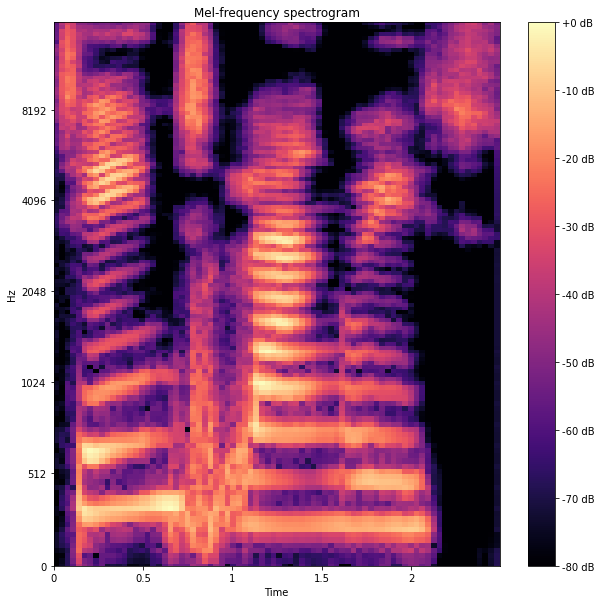

In [155]:
#Mel spectrogram 

spect = librosa.feature.melspectrogram(y=trimmed_signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=128)
  
fig, ax = plt.subplots()
s_dB = librosa.power_to_db(spect, ref=np.max)
img = librosa.display.specshow(s_dB, x_axis='time', y_axis='mel', sr=sr, fmax=16000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [185]:
#Chunking in 10x10 matrix and computing mean and std

n=10
splits_mean = []
splits_std = []
for vsplit in np.array_split(spect, n):
  for hsplit in np.array_split(vsplit, n, axis=1):
    splits_mean.append(hsplit.mean())
    splits_std.append(hsplit.std())
res = np.hstack((np.array(splits_mean), np.array(splits_std)))

res.shape

(200,)

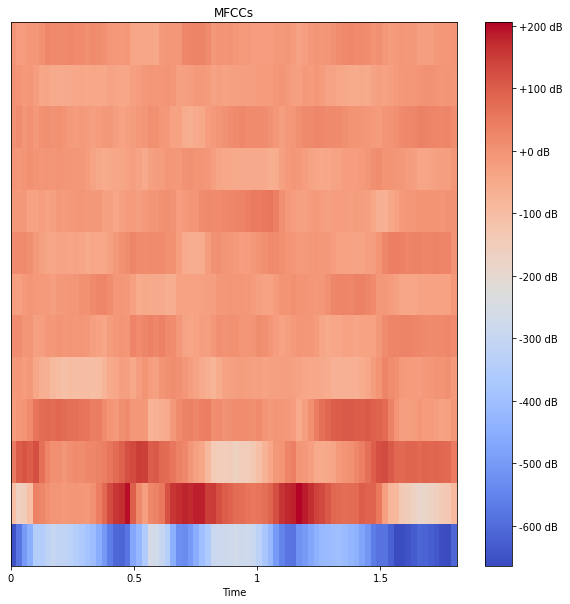

In [157]:
#Computing the mfccs

mfccs = librosa.feature.mfcc(y=trimmed_signal, sr=sr, n_mfcc=13, n_fft=N_FFT, hop_length=HOP_LENGTH)

fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='MFCCs')
plt.show()

In [187]:
#Computing mean and std of each mfcc

mfccs_mean = np.mean(mfccs, axis=-1) 
mfccs_std = np.std(mfccs, axis=-1)
res = np.hstack((mfccs_mean, mfccs_std))

res.shape

(26,)

### 3.2.2 Complete preprocessing pipeline

In [21]:
# audio processing pipeline

def audio_preprocessing(path_list, n_fft, hop_length, n_mfccs):
  
  d = dict()
  ix = 0

  for path in tqdm(path_list):
    row = dict()

    signal, sr = librosa.load(path, sr=None)

    signal = signal / signal.max()
    signal = signal - signal.mean()

    signal = nr.reduce_noise(signal, sr)
    signal, _ = librosa.effects.trim(signal, top_db=30, frame_length=n_fft, hop_length=hop_length)

    spect = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)

    n=10
    splits_mean = []
    splits_std = []
    for vsplit in np.array_split(spect, n):
      for hsplit in np.array_split(vsplit, n, axis=1):
        splits_mean.append(hsplit.mean())
        splits_std.append(hsplit.std())
    res = np.hstack((np.array(splits_mean), np.array(splits_std)))

    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfccs, n_fft=n_fft, hop_length=hop_length)
    mfccs_mean = np.mean(mfccs, axis=-1) 
    mfccs_std = np.std(mfccs, axis=-1)
    res = np.hstack((res, mfccs_mean, mfccs_std)) 

    row = {f'feature_{k}':v for k,v in enumerate(res)} 

    row['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y=signal, frame_length=n_fft, hop_length=hop_length), axis=-1)[0]
    row['rms'] = np.mean(librosa.feature.rms(y=signal, frame_length=n_fft, hop_length=hop_length), axis=-1)[0]
    row['duration'] = signal.shape[0]/sr

    d[ix] = row
    ix=ix+1

  return pd.DataFrame.from_dict(d).T 

### 3.3.3 Development dataset audio preprocessing

In [22]:
audio_feat_dev_df = audio_preprocessing(dev_df['path'], n_fft=256, hop_length=128, n_mfccs=13)

100%|██████████████████████████████████████████████████████████████████████████████| 9854/9854 [09:44<00:00, 16.87it/s]


In [23]:
audio_feat_dev_df.shape

(9854, 229)

In [24]:
audio_feat_dev_df['duration'].describe()

count    9854.000000
mean        1.073845
std         0.481168
min         0.112000
25%         0.776000
50%         0.984000
75%         1.270000
max        12.608000
Name: duration, dtype: float64

After the preprocessing, and having removed the silent part, the maximum duration dropped to around 12.6 seconds.

### 3.3.4 Evaluation dataset audio preprocessing

In [26]:
audio_feat_eval_df = audio_preprocessing(eval_df['path'], n_fft=256, hop_length=128, n_mfccs=13)

100%|██████████████████████████████████████████████████████████████████████████████| 1455/1455 [01:17<00:00, 18.80it/s]


In [27]:
audio_feat_eval_df.shape

(1455, 229)

In [28]:
audio_feat_eval_df['duration'].describe()

count    1455.000000
mean        1.070596
std         0.416348
min         0.280000
25%         0.800000
50%         1.008000
75%         1.256000
max         3.072000
Name: duration, dtype: float64

## 3.3 Concatenating the features

In [35]:
#Development features

all_features_dev_df = pd.concat((features_dev_df, audio_feat_dev_df), axis=1)
all_features_dev_df.shape

(9854, 247)

In [36]:
all_features_dev_df.head(5)

,Self-reported fluency level _advanced,Self-reported fluency level _basic,Self-reported fluency level _intermediate,Self-reported fluency level _native,First Language spoken_English (Canada),First Language spoken_English (United States),First Language spoken_French (Canada),First Language spoken_Spanish (Venezuela),First Language spoken_Telugu,Current language used for work/school_English (Australia),...,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,zcr,rms,duration
0,1,0,0,0,0,1,0,0,0,0,...,23.810791,25.471319,24.108917,18.209015,19.726000,15.639566,18.870337,0.248213,0.071746,1.216
1,1,0,0,0,0,1,0,0,0,0,...,24.512121,12.478948,17.579300,11.045987,14.202245,12.852545,14.612741,0.152083,0.096245,0.712
2,1,0,0,0,0,1,0,0,0,0,...,25.499638,14.532240,17.237427,14.506787,15.087097,11.510954,10.727163,0.189590,0.073042,1.248
3,1,0,0,0,0,1,0,0,0,0,...,13.994290,14.086226,18.424812,12.207338,11.523486,10.039927,10.832930,0.114865,0.026275,0.880
4,1,0,0,0,0,1,0,0,0,0,...,17.193808,11.711819,13.213588,9.589790,11.360817,10.110891,9.092976,0.151930,0.037880,1.352


In [37]:
#Evaluation features

all_features_eval_df = pd.concat((features_eval_df_full, audio_feat_eval_df), axis=1)
all_features_eval_df.shape

(1455, 247)

In [38]:
all_features_eval_df.head(5)

,Self-reported fluency level _advanced,Self-reported fluency level _basic,Self-reported fluency level _intermediate,Self-reported fluency level _native,First Language spoken_English (Canada),First Language spoken_English (United States),First Language spoken_French (Canada),First Language spoken_Spanish (Venezuela),First Language spoken_Telugu,Current language used for work/school_English (Australia),...,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,zcr,rms,duration
0,0,0,0,1,0,1,0,0,0,0,...,21.538498,14.980685,19.621023,22.224569,10.910697,13.008160,9.018212,0.037682,0.220984,0.784
1,0,0,0,1,0,1,0,0,0,0,...,27.819592,14.745558,17.497665,15.041282,14.536757,11.422888,9.888848,0.174791,0.115871,1.096
2,0,0,0,1,0,1,0,0,0,0,...,27.627283,18.974943,17.592281,13.843173,16.488525,13.948853,8.713580,0.144671,0.064827,0.888
3,0,0,0,1,0,1,0,0,0,0,...,29.424150,13.284259,9.315860,12.156644,10.475239,16.071970,14.166965,0.176657,0.161820,0.456
4,0,0,0,1,0,1,0,0,0,0,...,29.415455,10.585127,27.610312,15.235620,21.173370,25.192852,9.434653,0.195933,0.090987,0.848


# 4. Model selection

In this section the default versions of several scikitlearn classificator are tested and compared using a PrettyTable object. Once the best one is chosen, it is proceeded with the features selection step and the fine tuning of the model.

The first analysis is made using all the features available.

In [45]:
classification_models = [
  SVC(random_state=42),
  DecisionTreeClassifier(random_state=42),
  RandomForestClassifier(random_state=42),
  ExtraTreesClassifier(random_state=42)
]

names = [
    'SVC',
    'DecisionTree',
    'RandomForest',
    'ExtraTrees',
]

In [68]:
t = PrettyTable()
t.field_names = ['model', 'accuracy']

for model, name in zip(classification_models, names):
    X = all_features_dev_df
    y = dev_df['action_object']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    t.add_row([name, accuracy_score(y_test, y_pred)])
  
print(t)

+--------------+---------------------+
|    model     |       accuracy      |
+--------------+---------------------+
|     SVC      | 0.37436591139668585 |
| DecisionTree |  0.4869800473452824 |
| RandomForest |  0.7095028745350017 |
|  ExtraTrees  |  0.6838011498140006 |
+--------------+---------------------+


The most promising models are the RandomForestClassifier and the ExtraTreesClassifier. Predicting the labels of the evaluation dataset, the first obtained 0.753 accuracy while the second 0.692 in the leaderbord. So it is chosen to go on for feature selection and fine tuning for the RandomForestClassifier.

# 5. Features selection

First let's use the RandomForest built-in methods which return the features importance.

In [74]:
rf = classification_models[2]
features = sorted(zip(rf.feature_names_in_, rf.feature_importances_), key = lambda x:x[1], reverse = True)
features[-20:]

[('feature_70', 0.0024874036181921364),
 ('feature_191', 0.002327392018557663),
 ('gender_female', 0.00043913683905526555),
 ('gender_male', 0.0004381221992171155),
 ('ageRange_22-40', 0.00033165181246230173),
 ('Self-reported fluency level _native', 0.00023976850217431262),
 ('ageRange_41-65', 0.0002292110643445767),
 ('Self-reported fluency level _advanced', 0.00017032309638458258),
 ('Current language used for work/school_English (United States)',
  0.00015487707363106106),
 ('Current language used for work/school_English (Canada)',
  0.0001543527506850008),
 ('First Language spoken_English (United States)', 0.00011693292456615169),
 ('ageRange_65+', 8.246228226258017e-05),
 ('First Language spoken_French (Canada)', 7.832177219296052e-05),
 ('Self-reported fluency level _basic', 5.249582869688943e-05),
 ('Current language used for work/school_English (Australia)',
  3.369458547932175e-05),
 ('First Language spoken_Telugu', 2.263713811139721e-05),
 ('First Language spoken_Spanish (Ve

The least important features are the ones representing the speaker features, so it is decided to train the model using only the audio extracted features.

In [93]:
X = audio_feat_dev_df
y = dev_df['action_object']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.7155901251268177


This second model obtained 0.765 accuracy score in predicting the evaluation dataset in the leaderbord. 

Let's try removing again the least important features.

In [108]:
features = sorted(zip(rf.feature_names_in_, rf.feature_importances_), key = lambda x:x[1], reverse = True)
to_remove = []
for f in features[-50:]:
  to_remove.append(f[0])

In [109]:
rf2 = classification_models[2]
X = audio_feat_dev_df.drop(columns=to_remove)
y = dev_df['action_object']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.7172810280689889


Removing the last 50 features, it improves the accuracy also in the leaderbord, obtaining 0.771 of accuracy. 

# 6. Fine Tuning

To perform the fine tuning part it is used the HalvingGridSearch method which allows to speed up the search since starts training whole the combinations of parameters on a subset of the data and at each iteration selects the best candidates and test them on a larger part of data until the best set of hyperparameters are left standing. For further information about HalvingGridSearch it is referred you to the documentation (https://scikit-learn.org/stable/modules/generate/sklearn.model_selection.HalvingGridSearchCV.html?highlight=gridsearch#sklearn.model_selection.HalvingGridSearchCV).

In [112]:
#Creating the parameters grid

criterion = ['gini', 'entropy']
n_estimators = [500, 1000, 2000]
max_features = ['sqrt','log2']
max_depth = [100, 200, None]
bootstrap = [True, False]

parameters = {'criterion': criterion,
             'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'bootstrap': bootstrap}

In [115]:
rforest = RandomForestClassifier(random_state=42)
rf_halving = HalvingGridSearchCV(estimator=rforest, param_grid=parameters, scoring='accuracy',
                                factor = 3, cv = 3, verbose=1, n_jobs = -1)

In [116]:
X = audio_feat_dev_df.drop(columns=to_remove)
y = dev_df['action_object']

In [117]:
rf_halving.fit(X, y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 364
max_resources_: 9854
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 364
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 24
n_resources: 1092
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 3276
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 9828
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                    n_jobs=-1,
                    param_grid={'bootstrap': [True, False],
                                'criterion': ['gini', 'entropy'],
                                'max_depth': [100, 200, None],
                                'max_features': ['sqrt', 'log2'],
                                'n_estimators': [500, 1000, 2000]},
                    scoring='accuracy', verbose=1)

In [125]:
print(rf_halving.best_estimator_) 
print('Accuracy: ', rf_halving.best_score_)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=100,
                       max_features='log2', n_estimators=2000, random_state=42)
Accuracy:  0.7381666961819633


Now the prediction on the X_test split of the best classifier are computed to obtain a comparable score with the other obtained in the Feature selection part.

In [126]:
rf_best = rf_halving.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
y_pred = rf_best.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.7527899898545823


# 7. Submission of the results

In [122]:
rf_best = rf_halving.best_estimator_

eval_pred = rf_best.predict(audio_feat_eval_df.drop(columns=to_remove))

submission_df = pd.DataFrame(columns=['Id','Predicted'])

submission_df['Id'] = eval_df.index
submission_df['Predicted'] = eval_pred
submission_df.to_csv('results2.csv', index=False)

The obtained result in the leaderbord is of 0.801 of accuracy score.

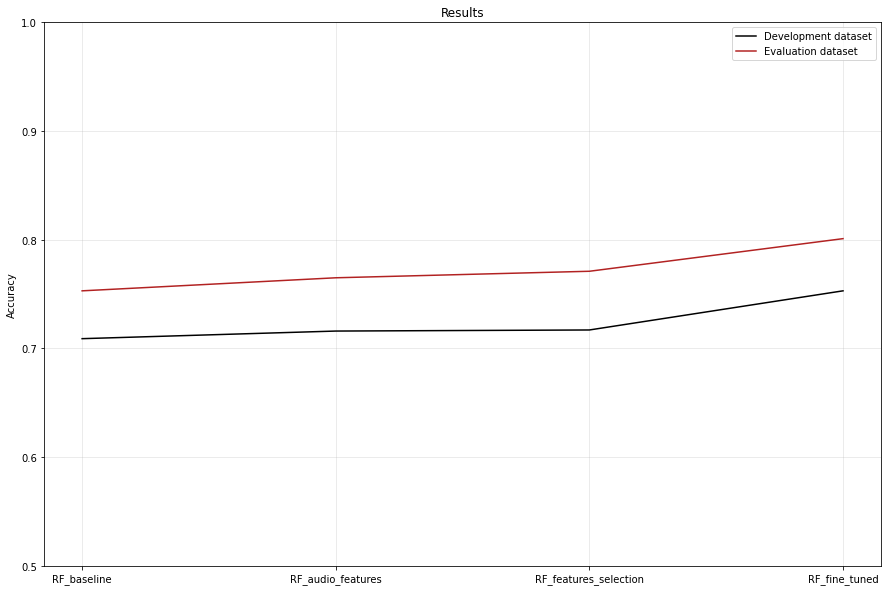

In [189]:
dev_results = np.array([0.709, 0.716, 0.717, 0.753])
eval_results = np.array([0.753, 0.765, 0.771, 0.801])
x=['RF_baseline', 'RF_audio_features', 'RF_features_selection', 'RF_fine_tuned']

results_df = pd.DataFrame((np.vstack((dev_results,eval_results))), columns=x)

plt.figure(figsize=(15,10))
plt.title('Results'), 

sns.lineplot(data=results_df.loc[0,:], color='black', label='Development dataset')
sns.lineplot(data=results_df.loc[1,:], color='firebrick', label='Evaluation dataset')
plt.ylabel('Accuracy')
plt.ylim((0.5,1))
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.show()